# Skimmer 📄⚕️
`Skim reading` is the act of quickly and superficially reading a text to pick up on the most important or significant details

`Project Objective` : Ease the reading of medical abstracts

`Data set (Medical Paper)` : https://arxiv.org/abs/1710.06071

`model used in the paper ` https://arxiv.org/abs/1612.05251




## Confirm GPU Access

In [165]:

# Check for GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [166]:
!nvidia-smi # this works on a local machine

/bin/bash: line 1: nvidia-smi: command not found


## Get the data
(the data set here exists within the paper they have a github )
`Github Link` : https://github.com/Franck-Dernoncourt/pubmed-rct

In [167]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls  pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [168]:
# start our experiment using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [169]:
# check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data
process data by `visualization`


In [170]:
#create a function to read the lines of a document
def get_lines(filenames):
 """
 Read the file name (file.txt) and returns the lines as a list
 Args :
      filename : a string that contains the target files
 Returns :
    list of string with one string perline from the target
 """
 with open(filenames , 'r' , encoding='utf-8') as f :
  return f.readlines()

In [171]:
# let's tead into the training lines
train_lines = get_lines(data_dir + "train.txt") # read the line in train.txt file
train_lines[:20]


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

our data needs to be represented like the following

>
   [{'line_number' : 0 ,
    'target' : 'BACKGROUND' ,
     'text' : 'Emotional eating is associated with oveeating and the development of obesity' ,
     'total_lines' : 11} ,
     ...]
>

In [172]:
def preprocess_text_with_line_numbers(filenames):
    """
    Returns a list of dictionaries with abstract line data.
    Processes the file, sorts the lines, and extracts the target label, text of the sentence,
    number of sentences, and sentence index.

    Args:
    filenames (str): Path to the file containing abstracts.

    Returns:
    list of dict: Each dictionary contains 'target', 'text', 'line_number', and 'total_lines'.
    """

    # Read all lines from the file
    input_lines = get_lines(filenames)

    abstract_lines = ""  # Initialize an empty string to accumulate lines of the current abstract
    abstract_samples = []  # Create an empty list to store processed abstract data

    for line in input_lines:
        line = line.strip()  # Remove leading and trailing whitespace from the line

        if line.startswith("###"):  # Check if the line indicates a new abstract ID
            if abstract_lines:  # Process the previous abstract if it exists
                process_abstract(abstract_lines, abstract_samples)

            # Start a new abstract
            abstract_lines = ""
        elif line:  # Check if the line is not empty
            abstract_lines += line + "\n"  # Append the line to the current abstract with a newline

    # Process the last abstract if there's any remaining data
    if abstract_lines:
        process_abstract(abstract_lines, abstract_samples)

    return abstract_samples

def process_abstract(abstract_lines, abstract_samples):
    """
    Processes a block of abstract lines and appends the data to the abstract_samples list.

    Args:
    abstract_lines (str): The raw text of the abstract.
    abstract_samples (list): The list where processed abstract data will be appended.
    """
    # Split the abstract into separate lines
    abstract_line_split = abstract_lines.splitlines()

    # Iterate through each line in the abstract
    for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        if "\t" in abstract_line:  # Ensure the line contains a tab
            target_text_split = abstract_line.split("\t", 1)  # Split into target and text
            if len(target_text_split) == 2:  # Ensure there are exactly two parts
                line_data = {
                    "target": target_text_split[0].strip(),  # Extract target label
                    "text": target_text_split[1].strip().lower(),  # Extract text and convert to lower case
                    "line_number": abstract_line_number,  # Line number in the abstract
                    "total_lines": len(abstract_line_split)  # Total lines in the abstract
                }
                abstract_samples.append(line_data)  # Append the data to the list


In [173]:

%%time
# this is a magic line that must be the first thing in the line or it wont work
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
# the name dev is equavilent to the validation , so you are free to name it either dev or validation
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples) , len(val_samples) , len(test_samples)


CPU times: user 785 ms, sys: 256 ms, total: 1.04 s
Wall time: 1.1 s


(180040, 30212, 30135)

turn data do a data frame

In [174]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)




,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [175]:
# Distirbution of lables in the training data
# this is good to see if there is an imbalance
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


This diagram represents how many sentences should be in abstract 
  it indicates that it goes from 5-25


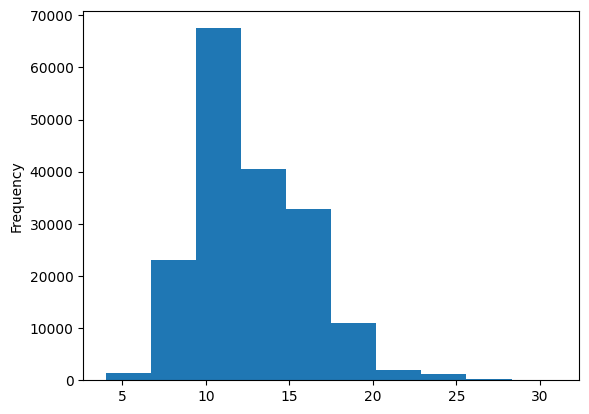

In [176]:
# Check lines lengths
train_df.total_lines.plot.hist()
print("This diagram represents how many sentences should be in abstract \n  it indicates that it goes from 5-25")

## Get list of sentences

In [177]:
# convert abstract lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences) , len(val_sentences) , len(test_sentences)

(180040, 30212, 30135)

In [178]:
# view 10 lines
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make Numeric labels

In [179]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=  False ) # if you put true it will turn to sparse if false it would be a matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot
#tensorflow might not work with sparse therefor we made it wrong



array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [180]:
# Extract labels ("target" columns and encode them into integers)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# this is turning text to numbers
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())#reshape(-1,1)))
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded  = label_encoder.transform(test_df["target"].to_numpy())

 # Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [181]:
# we can reverse engineer it to words by class names and number from label encoder
num_classes  = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

Before Modeling we will need to make a `baseline model` that we can gradually improve with time

```
 Model_0 : Naive Bayes with TF-IDF encoder (baseline)
 Model_1 : Conv1D with token embeddings
 Model_2 : Tensorflow Hub with pretrained feature extractor
 Model_3 : Conv1D with character embeddings
 Model_4 : Model_2 + Model_3 (same functionalities)
 model_5  : pretrain token embeddings + character embedding + postional embediing
```


## Model 0  Getting a baseline

In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create a pipeline
model_0 = Pipeline([
    # text to numbers
    ("tf-idf" , TfidfVectorizer()) ,
    # classifer
    ("clf" , MultinomialNB()) ,
])
# fit the pipeline to the training data
model_0.fit(X= train_sentences ,
            y= train_labels_encoded )

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [183]:
# evaluate baseline model on validation dataset
model_0.score(X = val_sentences ,
                 y = val_labels_encoded)

0.7218323844829869

In [184]:
# Make predictions using the baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [185]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Helper Functions
i will put the helper functions from the **mdbrouke deep learning repo** so no need to clone

In [186]:
from helper_functions import calculate_results


In [187]:
# calculate baseline results
baseline_results = calculate_results(y_true= val_labels_encoded ,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Prep the data for Modeling
if we need to work on deep sequene model we need to vectorize and embed our layers in order to use it for modeling

In [188]:
import tensorflow as tf
print(tf.__version__)


2.8.0


## Preparing the data to be in a numerical format

In [189]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [190]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [191]:
# how long is each sentencce on average
sent_lens = [len(sentence.split())for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

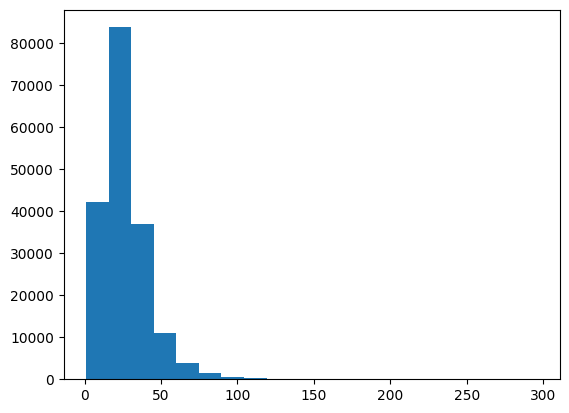

In [192]:
# What is the distrbution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens , bins = 20);

In [193]:
# How long of a sentence length convers 95% of the examples
output_seq_len = int(np.percentile(sent_lens , 95))
output_seq_len

55

In [194]:
# Maximum sequence length in the training set
max(sent_lens)

296

## Create a text vertorizer layer
text vectorizer is what it turns words to numbers

In [195]:
# how many vocab we have in the 20k dataset link : https://arxiv.org/abs/1710.06071
max_tokens = 68000


In [196]:
# creating the text vertorizer
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens ,  # number of words in a vocab
                                    output_sequence_length = output_seq_len # desired output length of vectorized sequence
                                    )


In [197]:
# adapt text vectorizer to training
text_vectorizer.adapt(train_sentences)

In [198]:
# test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text: \n {target_sentence}")
print(f"\n Length of text : {len(target_sentence.split())}")
print(f"\n Vectorized text : \n{text_vectorizer([target_sentence])}")


Text: 
 results warrant further exploration of ofatumumab in rrms .

 Length of text : 9

 Vectorized text : 
[[ 117 4802  298 6297    4 9350    5 7454    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


Now we will use `get_vocabulary()` and `text_vectorizer` so we can figure out information about the text

In [199]:
# How many words in the training vocabulary
#there is an already existing get vocabulary ,
# to represent most common use positive and for negative use negative values
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in a vocabulary {len(rct_20k_text_vocab)}")
print(f"Most common words in a vocabulary {rct_20k_text_vocab[:5]}")
print(f"Least common words in a vocabulary {rct_20k_text_vocab[:-5]}")

Number of words in a vocabulary 64841
Most common words in a vocabulary ['', '[UNK]', 'the', 'and', 'of']
Least common words in a vocabulary ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment', 'is', 'after', 'by', 'this', 'groups', 'as', 'an', 'from', 'that', 'randomized', 'between', 'not', 'trial', 'no', 'compared', 'control', 'be', 'significant', 'intervention', 'significantly', 'n', 'months', 'than', 'we', 'vs', 'rsb', 'lsb', 'clinical', 'placebo', 'baseline', 'ci', 'two', 'during', 'weeks', 'both', 'had', 'primary', 'mean', 'are', 'using', 'participants', 'there', 'all', 'time', 'years', 'pain', 'therapy', 'who', 'mg', 'more', 'effect', 'effects', 'but', 'risk', 'difference', 'outcomes', 'total', 'care', 'rate', 'efficacy', 'received', 'associated', 'higher', 'respectively', 'days', 'analysis', 'outcome', 'use', 'one', 'week', 'women', 'may', 'randomly', 'levels', 'followup', 'will', 'inc

we can also figure out the configuration use `get_config()`

In [200]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

Even though `token_vectorization` layers maps the words to numbers directly but that doesnt mean we got the the absloute relationship within the numbers therefor we get to use `embdding` layers

what we will need to make embedding layers
  * input_dim = size of vocab
  * output_dim  = dimention of the output embedded layer

In [201]:
#create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab) ,
                               output_dim = 128 , #different sizes lead to differnt results usually but as a standard put 128
                               mask_zero = True ,   # masking is used to let the model be informed if a part of data shall be ignored in order to save space
                               name = "token_embedding"
                               )
#showcase of embedding
print(f"Sentence before vectorization :\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding :\n {embedded_sentence}")
print(f"Sentence's shape after embedding :\n {embedded_sentence.shape}")



Sentence before vectorization :
results warrant further exploration of ofatumumab in rrms .

Sentence after vectorization [[ 117 4802  298 6297    4 9350    5 7454    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding :
 [[[-0.03555515  0.02029406  0.01884783 ...  0.01295701  0.03051266
   -0.04638425]
  [-0.00286303  0.00485929  0.00230243 ...  0.02985675  0.00809859
   -0.01170669]
  [ 0.00404365 -0.00066924  0.02778191 ...  0.0198567   0.04741992
   -0.00347986]
  ...
  [ 0.00880805  0.00670324  0.0220197  ... -0.0247339   0.0121619
   -0.01539062]
  [ 0.00880805  0.00670324  0.0220197  ... -0.0247339   0.0121619
   -0.01539062]
  [ 0.00880805  0.00670324  0.0220197  ... -0.0247339   0.0121619
   -0.01539062]]]
Sentence's shape after embedding :
 (1, 55, 128)


## Creating Datasets
do create datasets quickly we need API's like `tf.data` which provides quick data loading
to do so we need to turn to turn our data into batches  either using `batch()` or `prefetch()`  
and to determine the optimal amount of data to compute we will use the `tf.data.AUTOTUNE`

steps :
   * slice
   * turn to batches

In [202]:
# now lets turn our data to tensoflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [203]:
# Take the sliced data and turn it into batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset


<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 : Conv1D with token embeddings

lets put this structure in mind

```
Input(text) - > Tokenize -> Embedding -> Layers -> Output (label probabilities)

```
**Note**: what would be changable would be layers , since text need to be embedded before actually figuring out which most pattern is optimal therefor adjusting layers to needs is to be put in consideration

the modeling workflow would be in
 * Building model
 * Train model
 * Evaluate model

In [204]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Get summary of Conv1D model
model_1.summary()


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 5)                 325

As shown above ⬆️ most of the training happened in the embedding layer but if you look at the training data it is way too much on the device , so it is better to take `10%` of the data  , usually using `10%` is a standard

**Note** : Usually this practice is used for quick training

In [205]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 67s 118ms/step - loss: 0.9203 - accuracy: 0.6327 - val_loss: 0.6890 - val_accuracy: 0.7364
Epoch 2/3
562/562 [==============================] - 67s 120ms/step - loss: 0.6604 - accuracy: 0.7532 - val_loss: 0.6300 - val_accuracy: 0.7713
Epoch 3/3
562/562 [==============================] - 68s 120ms/step - loss: 0.6187 - accuracy: 0.7727 - val_loss: 0.5975 - val_accuracy: 0.7869


In [206]:
# lets validate the data
model_1.evaluate(valid_dataset)


945/945 [==============================] - 6s 7ms/step - loss: 0.5996 - accuracy: 0.7864


[0.5996034145355225, 0.7864093780517578]

In [207]:

# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.2419097e-01, 1.5603548e-01, 8.0247648e-02, 3.1241947e-01,
        2.7106388e-02],
       [4.5628500e-01, 2.4857655e-01, 1.6005706e-02, 2.7089739e-01,
        8.2353773e-03],
       [1.9449395e-01, 1.1644912e-02, 1.4259998e-03, 7.9237974e-01,
        5.5493230e-05],
       ...,
       [3.5271635e-06, 5.4497062e-04, 4.7573567e-04, 2.4566336e-06,
        9.9897337e-01],
       [6.2007759e-02, 4.7845829e-01, 1.2633780e-01, 8.6756229e-02,
        2.4643989e-01],
       [1.3964355e-01, 7.1010727e-01, 4.3625377e-02, 5.1285014e-02,
        5.5338778e-02]], dtype=float32)

The function tf.argmax is used to find the index of the maximum value along a specified axis (in this case, axis 1 for class probabilities). This index corresponds to the class with the highest probability.|

In [208]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [209]:

# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.64093737587714,
 'precision': 0.7826484647652177,
 'recall': 0.7864093737587714,
 'f1': 0.7837678329494464}

In [210]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2 : Feature extraction with pretrained token embedding
since the paper used a pre-trained embedding we will try to use the `pretrained universal sentence encoder embedding` that is in the tensorflow hub

our sequence will go as the following
```
Inputs(string) - > Pretrained embedding from tensorflow hub - > layers -> outpts
```
What we are doing right now is the **feature extraction transfer learning** this makes the model take the patterns from somethng else that it learnt elsewhere

when you do this mind the following :
* we will use the USE (Universal sentence encoder embedding) and do do to we will use `hub.Keras.Layer`
* Freeze the embedding `trainable = False` cause we will add our own layers to make the model work on our own data

In [211]:
# Downloading USE from tensorflow hub
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2",
                                        trainable=False,
                                        name="universal_sentence_encoder")
tf_hub_embedding_layer

In [212]:
# lets test this now on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence \n {random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding :\n {use_embedded_sentence[0][:30]} (truncated output)...")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")


Random training sentence 
 nebulized budesonide may be used as an alternative to sc because of its equal effectiveness and lesser systemic adverse effects .

Sentence after embedding :
 [-2.2180669e-02 -7.9931815e-05 -7.4656330e-02 -4.8164554e-02
  3.1342804e-02 -6.7812479e-03 -7.2915382e-03 -2.7258955e-02
  7.5189248e-02  7.4548990e-02  4.2059708e-02 -4.3780925e-03
  2.6986822e-02  8.3732612e-02 -1.1397023e-02 -1.4231395e-02
 -7.2811671e-02 -8.2781307e-02 -5.9262455e-02 -1.2279435e-02
  8.2944155e-02 -3.3536479e-02 -6.0088016e-02 -3.6171425e-02
 -3.2850012e-02 -6.0498598e-03 -5.6708239e-02  5.2493125e-02
  9.4340974e-03  8.7413199e-02] (truncated output)...
Length of sentence embedding:
512


## Building and fitting NLP feature extraction model from TensorFlow Hub

In [213]:
pip install tensorflow==2.8.0

In [214]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype= tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Get a summary of the model
model_2.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dense_20 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Checking the summary of our model  we notice that the non trainable data is way too high this comes to the the fact that you made the `trainable = False` that we initiated when we were doing the USE ( Universal Sentence Encoder )

now that we trained our model only the top 2 output layers will be trained

In [215]:
# fit feature extractor model for 3 epochs
#since we are using the feature extraction , we may be able to use 10% of our data
model_2.fit(train_dataset ,
            steps_per_epoch = int(0.1 * len(train_dataset)) ,
            epochs = 3  ,
            validation_data = valid_dataset ,
            validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 24s 37ms/step - loss: 0.9161 - accuracy: 0.6490 - val_loss: 0.7952 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 0.7678 - accuracy: 0.7022 - val_loss: 0.7553 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7531 - accuracy: 0.7120 - val_loss: 0.7418 - val_accuracy: 0.7074


In [216]:
# now we make evaluation and do to so we need to work on the validation set
model_2.evaluate(valid_dataset)

945/945 [==============================] - 27s 28ms/step - loss: 0.7427 - accuracy: 0.7125


[0.742662787437439, 0.7125314474105835]

In [217]:
# now it is time to make a prediction based on our model 2 and our validated data
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.41007897, 0.3854528 , 0.00231336, 0.19507332, 0.00708164],
       [0.3283988 , 0.515714  , 0.00314462, 0.14917023, 0.00357238],
       [0.23553388, 0.14765368, 0.01485782, 0.56873065, 0.03322387],
       ...,
       [0.00168808, 0.00617539, 0.05747966, 0.00098657, 0.9336702 ],
       [0.00449583, 0.05057972, 0.18899775, 0.00184796, 0.75407875],
       [0.17339207, 0.22691794, 0.53222233, 0.00828152, 0.05918608]],
      dtype=float32)

now we will conver the prediction of model 2 to classes and do do so we will be using `argmax()`.

`argmax()` : can be used for class selection and it does select the highest probability as the predicted label



In [218]:
#conversion process
model_2_preds = tf.argmax(model_2_pred_probs , axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [219]:
# now we will be calculating the results using our helping functions calculate_results from the helper file
model_2_results = calculate_results(y_true = val_labels_encoded ,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.25314444591552,
 'precision': 0.7125657968898493,
 'recall': 0.7125314444591553,
 'f1': 0.7094225740652268}

## Model 3 : Conv1D with character embeddings

this one differes from token embedding like so

`Token embedding` (Skimmer , Project ) = both the words `skimmer` , `project` gets turned into feature fector like so ` ([0.0088])`
`character embedding` goes like (s , k , i , m , m , e , r , p, r , o ,j , e ,c ,t) , basically it takes the letters (characters)  and turns each character to a feature vector like so ` ([0.0088])`

steps to make it work
  * Split the text into characters
  * use Text vectorization
  * use embedding layers





In [220]:
# Make a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))
# test the spliting the normal sentences into a character separated
split_chars(random_training_sentence)

'n e b u l i z e d   b u d e s o n i d e   m a y   b e   u s e d   a s   a n   a l t e r n a t i v e   t o   s c   b e c a u s e   o f   i t s   e q u a l   e f f e c t i v e n e s s   a n d   l e s s e r   s y s t e m i c   a d v e r s e   e f f e c t s   .'

⚠️in order to proceed in this we have to turn the dataset to a splitted data ( train , val , test ) data

In [221]:
#splitting process will be using the previous function along the previous dataset
train_chars = [split_chars(sentence)for sentence in train_sentences ]
val_chars = [split_chars(sentence)for sentence in val_sentences ]
test_chars = [split_chars(sentence)for sentence in test_sentences ]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

Now to figure our how long does the vectorized character shall be , we need to check the distirbution of the character length


In [222]:
# lets fetch the average character length
char_lens = [len(sentence)for sentence in train_sentences]
mean_char_length = np.mean(char_lens)
mean_char_length

149.3662574983337

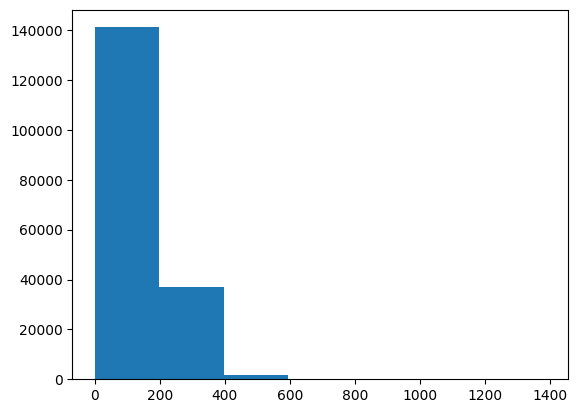

In [223]:
import matplotlib.pyplot as plt
plt.hist(char_lens , bins = 7);

from the graph we can tell that the sequences between 0 and 200


In [224]:
#Find what character lengeth covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens , 95))
output_seq_char_len

290

ok now we have got the sequence langth that covers 95% of the sequence , and we will be using the `TextVectorization` layer and all the needed parameters for the `TexxtVectorization`

`max_tokens` will be the total number of differenct characters in the sequence to 28 , 26 letters and space , and out of vocabulary and unknown tokens

In [225]:
#Lets get all characters for the character level embeddin g
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [226]:
# lets create a token vectorizer for our character based  level
NUM_CHAR_TOKENS = len(alphabet) + 2  # 2 for space and OOV(Out of vocabulary )tokens along the alphabets
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS ,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = "lower_and_strip_punctuation" ,
                                    name = "char_vectorizer")
#Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

now we will be using `get_vocabulary()` that will let us do the following
* Most common characters
* Least common characters
* Number of different characters


In [227]:
# check vocabulary characteristrics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in a character vocab : {len(char_vocab)}")
print(f"Most common 5 character vocab : {char_vocab[:5]}") # positive values for most common
print(f"Least common 5 character vocab : {char_vocab[-5:]}") # negative values for least common

Number of different characters in a character vocab : 28
Most common 5 character vocab : ['', '[UNK]', 'e', 't', 'i']
Least common 5 character vocab : ['k', 'x', 'z', 'q', 'j']


to ensure things are working lets do this on a randomized text

In [228]:
# test out on a randomized character
random_train_chars = random.choice(train_chars)
print(f"Charctified text :\n{random_train_chars}")
print(f"length of chars : {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\n Vectorized chars \n{vectorized_chars}")
print(f"\n Length of  Vectorized chars \n{len(vectorized_chars[0])}")

Charctified text :
i t   i s   u n c l e a r   i f   h o l d i n g   a n g i o t e n s i n - c o n v e r t i n g   e n z y m e   i n h i b i t o r s   (   a c e i   )   o r   a n g i o t e n s i n   r e c e p t o r   b l o c k e r s   (   a r b   )   p r i o r   t o   c o r o n a r y   a n g i o g r a p h y   r e d u c e s   c o n t r a s t - i n d u c e d   a c u t e   k i d n e y   i n j u r y   (   a k i   )   .
length of chars : 170

 Vectorized chars 
[[ 4  3  4  9 16  6 11 12  2  5  8  4 17 13  7 12 10  4  6 18  5  6 18  4
   7  3  2  6  9  4  6 11  7  6 21  2  8  3  4  6 18  2  6 25 19 15  2  4
   6 13  4 22  4  3  7  8  9  5 11  2  4  7  8  5  6 18  4  7  3  2  6  9
   4  6  8  2 11  2 14  3  7  8 22 12  7 11 23  2  8  9  5  8 22 14  8  4
   7  8  3  7 11  7  8  7  6  5  8 19  5  6 18  4  7 18  8  5 14 13 19  8
   2 10 16 11  2  9 11  7  6  3  8  5  9  3  4  6 10 16 11  2 10  5 11 16
   3  2 23  4 10  6  2 19  4  6 27 16  8 19  5 23  4  0  0  0  0  0  0  0
   0  0  0  0  0  0  

if you notice above ⬆️ that the last values of the vectorized text ( which is shorter than the length of `290`) gets padded with zeros just for length ensurance for all sequences

⚠️since we have added `lower_and_strip_punctuation` and the `split` for white space it will not be taken in consideration in our tokenization either `white spaces ` or `@` etc


## Creating a character level embedding
to do so you will need the followin g

*   `Tensorflow.keras.layers.Embedding`

*   `input_dim` = will be the same length of our character vocabs

*   `output_dim`  = 25 like the paper we are working on



In [229]:
# Creation of an embedding layer
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS ,
                              output_dim = 25 , #embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero = False , # this effects the Model 5  therefor lets make it false ,
                              name = "char_embed"

                              )

# lets test the character embedding layer
print(f"Characterized text (before vectorization and embedding :\n {random_train_chars}\n)")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")


Characterized text (before vectorization and embedding :
 i t   i s   u n c l e a r   i f   h o l d i n g   a n g i o t e n s i n - c o n v e r t i n g   e n z y m e   i n h i b i t o r s   (   a c e i   )   o r   a n g i o t e n s i n   r e c e p t o r   b l o c k e r s   (   a r b   )   p r i o r   t o   c o r o n a r y   a n g i o g r a p h y   r e d u c e s   c o n t r a s t - i n d u c e d   a c u t e   k i d n e y   i n j u r y   (   a k i   )   .
)
Embedded chars (after vectorization and embedding):
[[[ 0.02903375  0.00810982 -0.00575159 ... -0.03408483  0.00356835
    0.03083782]
  [-0.01854515 -0.03487676 -0.03068343 ...  0.01898453 -0.04491672
   -0.03521534]
  [ 0.02903375  0.00810982 -0.00575159 ... -0.03408483  0.00356835
    0.03083782]
  ...
  [-0.01270384 -0.03198083  0.02148864 ...  0.00733633 -0.03444909
   -0.04140786]
  [-0.01270384 -0.03198083  0.02148864 ...  0.00733633 -0.03444909
   -0.04140786]
  [-0.01270384 -0.03198083  0.02148864 ...  0.00733633 -0.03444909


##  Being a Conv1D model to fit on character embeddings
this model will be like `model_1` but it has extra character level sequence  

```
Input(character-level-text) ->Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output(label probability)
```

In [230]:
# Make Conv1D on chars only
inputs = layers.Input(shape = (1 ,) , dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64 , kernel_size  = 5 , padding="same" , activation = "relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes , activation = "softmax")(x)
model_3 = tf.keras.Model(inputs = inputs ,
                         outputs = outputs ,
                         name = "model_3_char_embedding")
# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()


Model: "model_3_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_21 (Dense)            (None, 5)      

now before fitting we will be batching our data  and then we will fit 10% of these batches

⚠️ Using `PrefetchedDataset` before fitting helps to overlap data loading and training, which can speed up the training process by ensuring that data is preloaded and ready when needed. It reduces data pipeline bottlenecks, leading to more efficient use of GPU or CPU resources.

In [231]:
# lets create char dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset



<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [232]:

# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 29ms/step - loss: 1.2674 - accuracy: 0.4801 - val_loss: 1.0615 - val_accuracy: 0.5701
Epoch 2/3
562/562 [==============================] - 16s 28ms/step - loss: 1.0183 - accuracy: 0.5912 - val_loss: 0.9507 - val_accuracy: 0.6323
Epoch 3/3
562/562 [==============================] - 16s 28ms/step - loss: 0.9362 - accuracy: 0.6350 - val_loss: 0.8760 - val_accuracy: 0.6636


In [233]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.20980835, 0.44842225, 0.05487138, 0.20094965, 0.08594846],
       [0.1676806 , 0.5274306 , 0.02908525, 0.1484692 , 0.12733442],
       [0.13249601, 0.39834076, 0.21739975, 0.13153286, 0.12023063],
       ...,
       [0.02378578, 0.0541683 , 0.18775629, 0.05315381, 0.68113583],
       [0.03116436, 0.06955966, 0.6056439 , 0.05760335, 0.23602867],
       [0.53241915, 0.2975936 , 0.07883245, 0.07157235, 0.01958247]],
      dtype=float32)

In [234]:

# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 2, 0])>

In [235]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.44750430292598,
 'precision': 0.6477695853249062,
 'recall': 0.6544750430292599,
 'f1': 0.6439974412965834}

## Model 4 : Combining pretrained token embeddings + character embeddings

Model 4 can be considered as a `hybrid embedding layer ` meaning both types of embdeddings are within it

now to execure that we will need these steps
  

1.   Create a token level model like `( model_1 )`
2.   Create a character level like `(model_3)`
3.   Use `Layers.Concatenate` in order to merge both outputs of step `1` and `2`
4. Build an output layers [Neural Networkss for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251)
5. Construct a model which takes tokens and character sequences as inputs and makes the out put of label probabilities

In [236]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)
# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. create output layer additonal to the one in 4.2 in the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200 , activation = "relu")(combined_dropout) # the result would be different due the different shape of embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes , activation = "softmax")(final_dropout)

# 5. Construct the model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

# 5. Get the summary of the model 4
model_4.summary()


Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

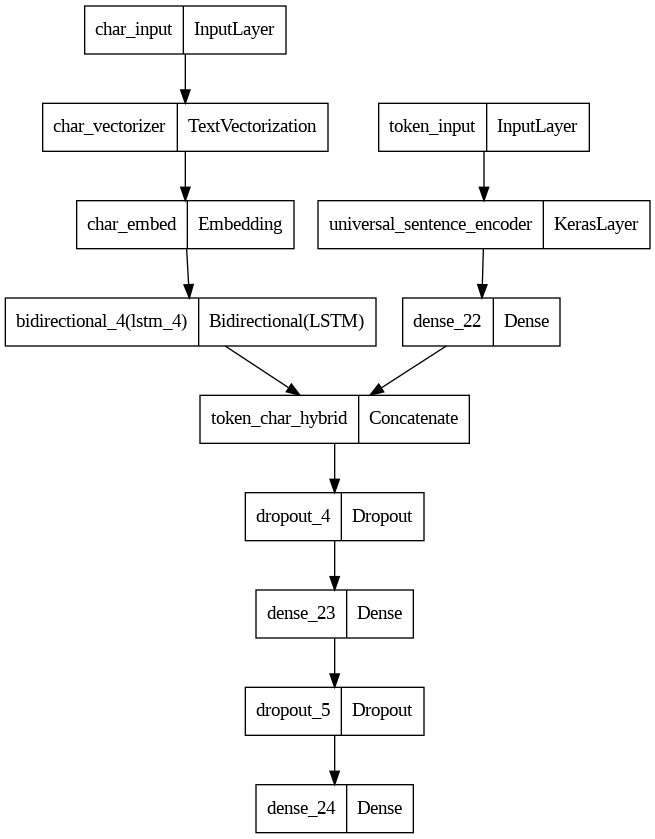

In [237]:
#plotting the model_4 for token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

⚠️ The paper uses `tf.keras.optimizers.SGD` to optimize but we will uses `tf.keras.optimizers.Adam`
paper : section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam

In [238]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), #
                metrics=["accuracy"])

Also for quicker experiments we will be needing to fit the model on 10% of the dataset (train , vlaidation ) batches , but this model requires two inputs `token level sequence` and ` character level sequence` to tdo this we will use
`tf.data.Dataset`

`((token_data , char_data) , (label))`

In [239]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels
# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
#  same steps for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [240]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting a model on token and character-level sequence

In [241]:

# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 191s 318ms/step - loss: 0.9674 - accuracy: 0.6145 - val_loss: 0.7813 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 172s 306ms/step - loss: 0.7908 - accuracy: 0.6931 - val_loss: 0.7184 - val_accuracy: 0.7247
Epoch 3/3
562/562 [==============================] - 179s 319ms/step - loss: 0.7717 - accuracy: 0.7064 - val_loss: 0.6906 - val_accuracy: 0.7320


In [242]:

# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 69s 73ms/step - loss: 0.6932 - accuracy: 0.7351


[0.6931951642036438, 0.7351383566856384]

In [243]:

# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs


array([[3.6352000e-01, 4.6881023e-01, 3.6547955e-03, 1.5340896e-01,
        1.0605988e-02],
       [3.4762630e-01, 4.6195650e-01, 4.4711614e-03, 1.8369192e-01,
        2.2541278e-03],
       [2.9031438e-01, 1.6279203e-01, 5.8037948e-02, 4.2530221e-01,
        6.3553430e-02],
       ...,
       [6.5923535e-04, 8.1588319e-03, 3.6033042e-02, 1.8376281e-04,
        9.5496505e-01],
       [5.1709670e-03, 3.9216466e-02, 2.1811247e-01, 1.8074767e-03,
        7.3569262e-01],
       [2.1179233e-01, 3.8556039e-01, 3.3517441e-01, 2.2142787e-02,
        4.5330122e-02]], dtype=float32)

In [244]:

# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [245]:

# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.51383556202833,
 'precision': 0.7352249896583141,
 'recall': 0.7351383556202833,
 'f1': 0.7318785704424327}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings
in model_4 it was noticable that the perfomance was increased due using both token and character embeddings ,  in this model we will do `feature engineering`
`feature engineering` is applying the known knowledge to build features as input for the model  you are creating
here it is important to classify the sequence here
in the abstract we have `OBJECTIVE` and `CONCLUSIONS` these sequences are preferable to be in a specific order


---
Preferable order
* `OBJECTIVE`
* `METHODS`
* `METHODS`
* `METHODS`
* `RESULT`
* `CONCLUSION`

⚠️: You may proceed with `BACKGROUND` if you like it is a preferance



**How can we walkthorugh that issue since we cant engineer the sequence into the training data?**
   we can encode the order since we have a function that helps us to retreive line number with the specific text `process_text_with_line_numbers()`  , this function reads the text files counts the line of the abstract and number of each line within the abstract

   this leads to have two values we can use `line_number` , `total_lines`

   these two values can be considered the `positional embedding` values that would be helpful to pass our model with since they rely on where sentence appear / index
   


In [246]:
train_df.head()


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


## Creating postitional embeddings
gladly we have `line_number` , and `total_lines` as numerical which is good since it will let us pass to the model right away no need for conversions


---



**Ok what if my model compares `line_number` with another `line_number` ?**

    to avoid this lets use `one_hot_encode` to encode features of `line_number` and `total_lines` features using a tool called `tf.one_hot`

**What does `tf.one_hot` do ?**

    It returns one-hot-encpded tensor . it accepts both arrays and tensors as input and `depth` parameter determines the dimension of the returned tensor

**Ok what depth shall we set it to?**

    to decide we need to check how `line_number` is distirbuted
   
   


In [247]:
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

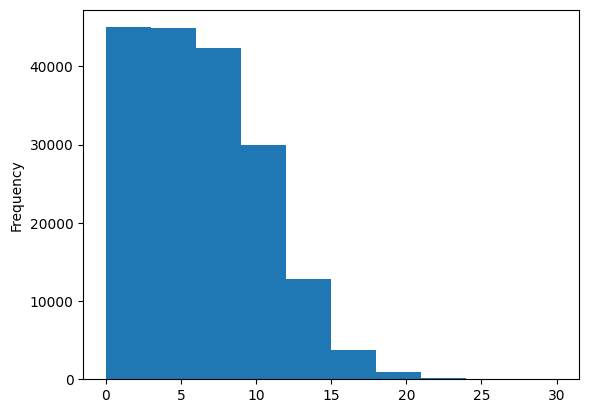

In [248]:
# Check the distirbution of "line_number" column
train_df.line_number.plot.hist()

⬆️ Looking at the graph above you will notice that the `line_number` is 15 in their positioor less  
, now we have obtained the informatin that we need for the to use the `depth` for the `tf.one_hot` which is 15

Since we have set the depth to 15 this means that any `line_number` > 15 will be set a tensor of 0's and any `line_number` < 15 will be turned into 0's the only values that will be 1 is the one where `line_number` = 15

In [249]:
# now we will be using tensorflow to create one hot enconded tensor of our line number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)



In [250]:

# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]


(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

now lets move to the next paramenter we have which is `total_lines`

In [251]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
12,24468
11,23639
13,22113
10,19400
14,18438
15,14610
9,12285
16,10768
8,7464


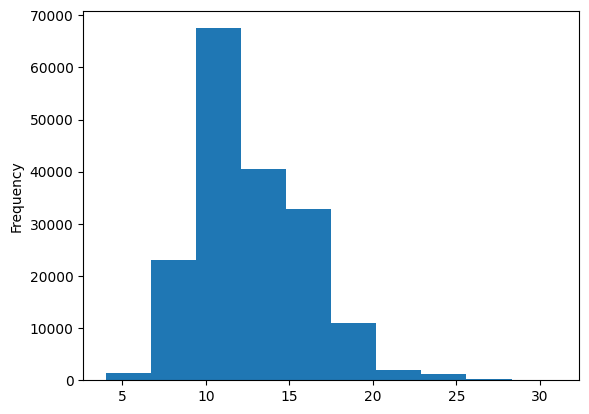

In [252]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

now if you look at the `total_lines` you will see tha the frequency goes from 21 and below
we can confirm the this information by using `np.percentile().`
`np.percentile` = is the tool that shows value of coverage  


In [253]:
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of sa

21.0

In [254]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=21)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=21)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=21)

In [255]:
# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 21]),
 <tf.Tensor: shape=(10, 21), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.,

## Lets try building the trio embeddings model
we have got positional tensors ready right now both of `line_number` and `total_lines`



---

Now what do we need to do in order to build such model??


1.   Build a token based model like `model_1`
2.   Create a character level likr `model_3`
3.   Create `line_number` model (we will use the one hot encoded tensor and pass it though )
4.   Create `total_lines` model (we will use the one hot encoded tensor and pass it though )
5.   Combine both of model_1 and model_3 outputs using the `layers.concatinate` tool for hybrid embedding combination
6.   Combine the positional embeddings together of `line_number` and `total_lines` and use `layers.Concatinate` to merge the token positional embeddings
7. make an outpit layer for the the trio embeddings ( token , character , positions) and make the output of the predicted labels
8. combine (token + character + positional) embeddigns inputs and put the output of the merged trio embeddigns (point number 7 ) and ude `tf.keras.Model`


In [256]:
# 1. Token inputs
token_inputs = layers.Input(shape=[] , dtype=tf.string , name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128 , activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs ,
                             outputs = token_outputs)
# 2. Char inputs
char_inputs = layers.Input(shape=(1,) , dtype = tf.string , name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs ,
                            outputs = char_bi_lstm)
# 3. line numbers inputs
line_number_inputs = layers.Input(shape = (15 , ) , dtype=tf.int32 , name = "line_number_inputs")
x= layers.Dense(32 , activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs
                                   , outputs = x)

# 4. Total line inputs
total_lines_inputs = layers.Input(shape = (21 , ), dtype = tf.int32 , name = "total_lines_inputs")
y = layers.Dense(32 , activation = "relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs = total_lines_inputs ,
                                  outputs = y )

# 5. Combine token and char embedding into hybrid embedding
combined_embeddings = layers.Concatenate(name = "token_char_hybrid_embeddings")([token_model.output , char_model.output])
z = layers.Dense(256 , activation = "relu")(combined_embeddings) # due being the data being complex it is better to put 256 units for dimensionality , proper performace , and the higher layer size the large enough to capture complex interactions
z = layers.Dropout(0.5)(z) # this is useful to prevent overfitting this forces the model to learn things that dont depend on specific input


# 6. combine the positional embeddings with combined token and char embeddings into a trio embeddings
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output ,
                                                                total_line_model.output ,
                                                                z])
# 7. Create output layer
output_layer = layers.Dense(5 , activation= "softmax" , name = "output_layers")(z)
# 8. Put together a model
model_5 = tf.keras.Model(inputs = [line_number_model.input ,
                                   total_line_model.input ,
                                   token_model.input ,
                                   char_model.input] ,
                         outputs = output_layer)
# Get a summary
model_5.summary()


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

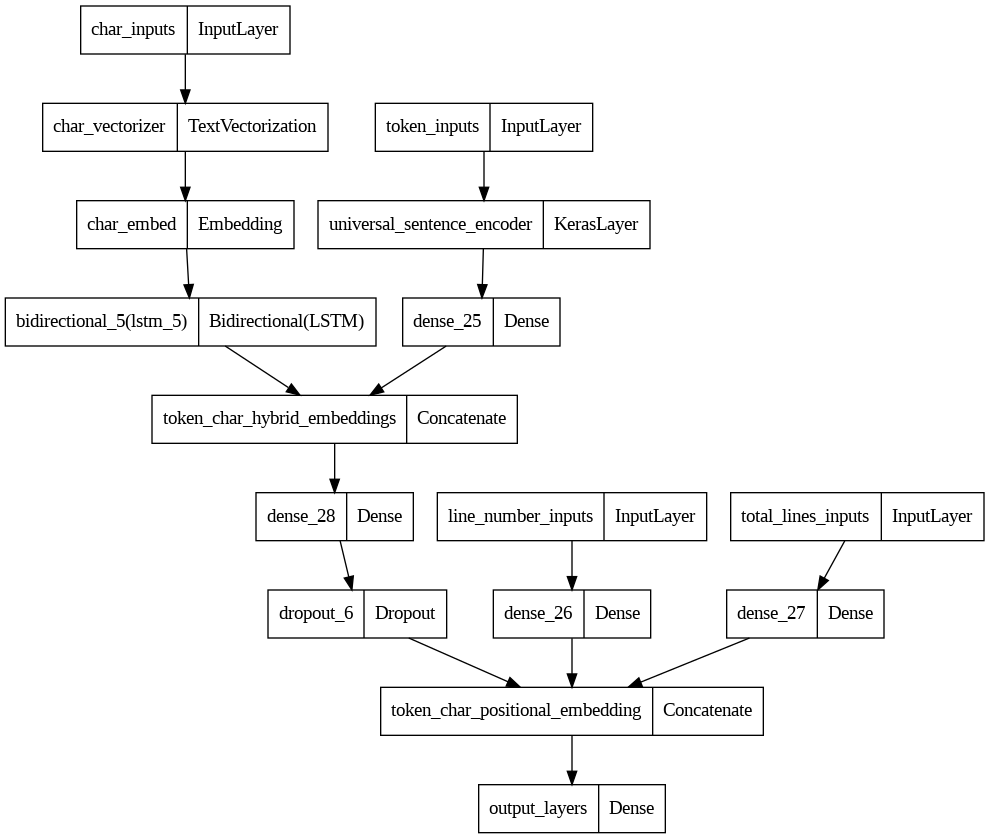

In [257]:

# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [258]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7888d5a76920> True
<keras.engine.input_layer.InputLayer object at 0x7888d59d7100> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7888deff4d90> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7889338ca050> False
<keras.layers.embeddings.Embedding object at 0x7888defe3ac0> True
<keras.layers.core.dense.Dense object at 0x7888d59d45b0> True
<keras.layers.wrappers.Bidirectional object at 0x7888d6e06800> True
<keras.layers.merge.Concatenate object at 0x7888d6e05c30> True
<keras.engine.input_layer.InputLayer object at 0x7888d5a3e980> True
<keras.engine.input_layer.InputLayer object at 0x7888d4e56890> True
<keras.layers.core.dense.Dense object at 0x7888d66b8640> True
<keras.layers.core.dense.Dense object at 0x7888d9302e00> True
<keras.layers.core.dense.Dense object at 0x7888d69fa2c0> True
<keras.layers.core.dropout.Dropout object at 0x7888d5a1d720> True
<keras.layers.merge.Concatenate object at 0x7888d5

since this model is very huge we will be using an extra paremeter before compiling our model and we will be adding this parameter along with the loss function `label_smoothing` which's goal is to prevent overfitting
also `label_smoothing` is good for generalization and not make the model focus on one aspect

In [259]:


# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # we put it here to reduce any over confidence and to improve the probability and it can inccrease the performance of the NN
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


## Before fitting our model we need to create a specific dataset for the trio embeddings
now what do we need


1.   `train_line_numbers_one_hot`
2.   `train_total_lines_one_hot`
3.    `train_sentences`
4.     `train_chars`

we will be batching these datasets using `PerfetchedDataset` and to turn things into tuples tf.data.Dataset.from_tensor_slices()



In [260]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [261]:

# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 176s 302ms/step - loss: 1.0958 - accuracy: 0.7254 - val_loss: 0.9853 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 172s 306ms/step - loss: 0.9668 - accuracy: 0.8158 - val_loss: 0.9499 - val_accuracy: 0.8268
Epoch 3/3
562/562 [==============================] - 176s 313ms/step - loss: 0.9511 - accuracy: 0.8239 - val_loss: 0.9389 - val_accuracy: 0.8281


In [262]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 70s 71ms/step


array([[0.50087273, 0.11749478, 0.01275957, 0.35167432, 0.01719862],
       [0.54820955, 0.11695776, 0.04543545, 0.27749157, 0.01190561],
       [0.27136242, 0.11697175, 0.12931594, 0.41275382, 0.06959607],
       ...,
       [0.03307201, 0.09031069, 0.04102647, 0.03149705, 0.8040938 ],
       [0.02662232, 0.23633437, 0.0827309 , 0.02598275, 0.62832963],
       [0.25155592, 0.56529844, 0.09641314, 0.04149094, 0.04524155]],
      dtype=float32)

In [263]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [264]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.49993380113861,
 'precision': 0.834322896238948,
 'recall': 0.8349993380113861,
 'f1': 0.8337918157999187}

## Model Results Comparisions

In [265]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.640937,0.782648,0.786409,0.783768
pretrained_token_embed,71.253144,0.712566,0.712531,0.709423
custom_char_embed_conv1d,65.447504,0.647770,0.654475,0.643997
hybrid_char_token_embed,73.513836,0.735225,0.735138,0.731879
tribrid_pos_char_token_embed,83.499934,0.834323,0.834999,0.833792


In [266]:

# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

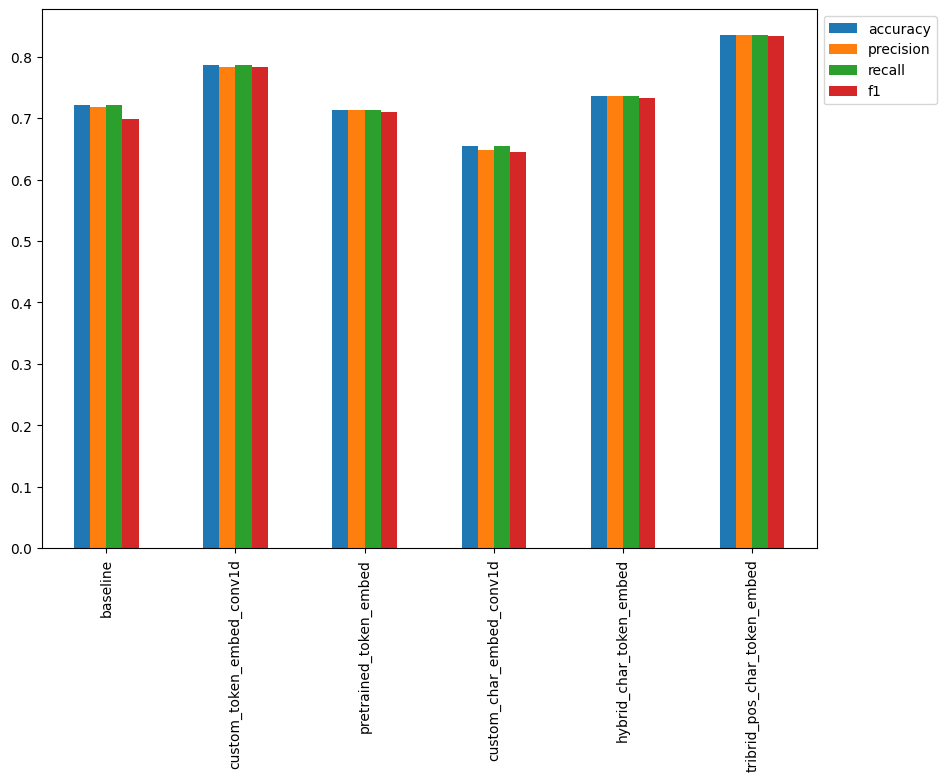

In [267]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

due the paper comparing their models by the F1 score lets try to do so in our own models

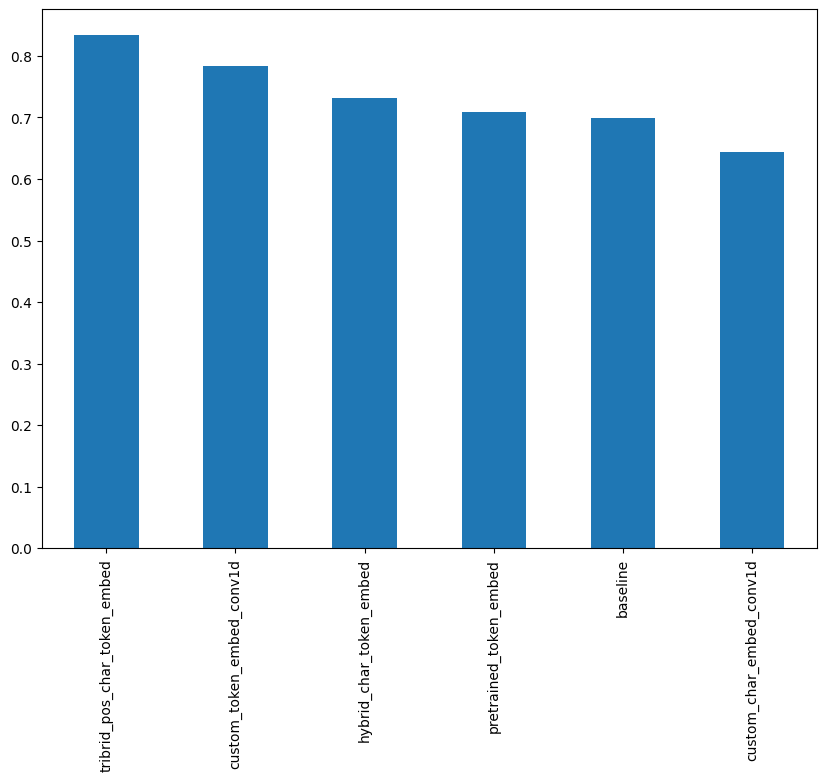

In [268]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load best peformance  model
you can use `save()` to save the model
and add the path for the  model  using the string

In [269]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [270]:
# save the optimal model
model_5.save("/content/drive/MyDrive/Skimmer/skimmer_tribid_model")

In [271]:
# load the best performing model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Skimmer/skimmer_tribid_model")

In [272]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]


945/945 [==============================] - 78s 78ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [273]:

# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.49993380113861,
 'precision': 0.834322896238948,
 'recall': 0.8349993380113861,
 'f1': 0.8337918157999187}

In [274]:
model_5_results

{'accuracy': 83.49993380113861,
 'precision': 0.834322896238948,
 'recall': 0.8349993380113861,
 'f1': 0.8337918157999187}

In [275]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [276]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

## Evaluate Model on a test dataset

In [277]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset



<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [278]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 67s 71ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [279]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results


{'accuracy': 82.87705326032852,
 'precision': 0.827405857641381,
 'recall': 0.8287705326032853,
 'f1': 0.8273692460190865}

## Find most wrong

In [280]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes


CPU times: user 7.82 s, sys: 30.7 ms, total: 7.85 s
Wall time: 8.05 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RE

In [281]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)


,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,9,OBJECTIVE,0.469616,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,9,BACKGROUND,0.326230,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,9,METHODS,0.781360,False
3,RESULTS,survival analyses were used to assess the asso...,3,9,METHODS,0.652869,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,9,RESULTS,0.652014,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,9,RESULTS,0.886812,True
6,RESULTS,multivariable analyses revealed that patients ...,6,9,RESULTS,0.567311,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,9,CONCLUSIONS,0.556785,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,9,RESULTS,0.478520,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,13,BACKGROUND,0.573544,True


In [282]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong


,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,7,METHODS,0.950647,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,19,BACKGROUND,0.933478,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,13,OBJECTIVE,0.931134,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,14,METHODS,0.926724,False
4391,CONCLUSIONS,-lsb- netherlands trial register ( http://www....,15,16,BACKGROUND,0.926715,False
...,...,...,...,...,...,...,...
26600,OBJECTIVE,the primary outcome measure of the study was t...,3,12,METHODS,0.838456,False
18206,OBJECTIVE,in a randomized controlled trial we examined t...,2,13,METHODS,0.838429,False
6846,RESULTS,the above variables were assessed at baseline ...,4,12,METHODS,0.837758,False
12269,RESULTS,patients received oral se tablets ( @ mcg ) or...,4,11,METHODS,0.837410,False


In [283]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9506469964981079, Line number: 4, Total lines: 7

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9334784746170044, Line number: 18, Total lines: 19

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9311341643333435, Line number: 0, Total lines: 13

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9267241954803467, Line number: 4, Total lines: 14

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9267153739929199, Line number: 15, Total lines: 16

Text:
-lsb- netherlands trial register ( http://www.trialregister.nl/trialreg/index.asp ) , nr @ , date of registration @ december @ . -rsb-

-----

Target: METHODS, Pred: BACKGROUND, Prob:

## Make example predictions

In [284]:
import json

with open("/content/skimmy_examples.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [285]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [286]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
entencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [287]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [288]:

# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [293]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=21)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 21), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]], dtype=float32)>

In [294]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars


['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [295]:
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

CPU times: user 2 s, sys: 13.1 ms, total: 2.01 s
Wall time: 1.91 s


array([[0.26045337, 0.14542162, 0.02420822, 0.5338615 , 0.03605523],
       [0.06486008, 0.03843421, 0.6907952 , 0.09849502, 0.10741547],
       [0.12322763, 0.07030933, 0.45317695, 0.236275  , 0.11701112],
       [0.08898878, 0.14557457, 0.560134  , 0.07674102, 0.1285617 ],
       [0.04897835, 0.12863031, 0.37274757, 0.04991359, 0.39973015],
       [0.03373197, 0.13067053, 0.5477966 , 0.04567802, 0.24212286],
       [0.02635246, 0.17616081, 0.08363778, 0.02755546, 0.6862935 ],
       [0.01887798, 0.15384136, 0.29252717, 0.03407919, 0.50067425]],
      dtype=float32)

In [296]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [298]:

# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes


['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [299]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
